# 1. Required libraries/modules

In [1]:
import pandas as pd
import numpy as np
import random
from surprise import KNNBasic, KNNBaseline
from surprise import SVD, SVDpp
from surprise import NormalPredictor 
from surprise import Dataset
from surprise import Reader
from tabulate import tabulate
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise import accuracy
import time
import matplotlib.pyplot as plt

# 2. Load data

In [2]:
full_df = pd.read_csv('data/full_data_cleaned.csv')
full_df.head(2)

,author_id,rating_x,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,...,price_usd_x,brand_id,ingredients,limited_edition,out_of_stock,sephora_exclusive,highlights,primary_category,num_rating,niche_product
0,1238130325,4,1.0,NaN,0,0,0,3/12/23,I love this lippy…it makes my lips soft and al...,Yumm,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0
1,27991208736,3,1.0,0.0,1,1,0,3/9/23,ive tried my friend’s a few times and it does ...,overrated/overpriced,...,24.0,6125,"['Diisostearyl Malate, Hydrogenated Polyisobut...",0,0,1,"['allure 2019 Best of Beauty Award Winner', 'C...",Skincare,1227,0


# 3. Extract data for training

In [3]:
# select relevant columns
rating_df = full_df[['author_id', 'product_id', 'rating_x', 'submission_time']]
# rename columns
rating_df.columns = ['userID', 'itemID', 'rating', 'timeStamp']
# convert "character" to "dateTime"
rating_df.loc[:,'timeStamp'] = pd.to_datetime(rating_df['timeStamp'], format='mixed')
rating_df.head()

,userID,itemID,rating,timeStamp
0,1238130325,P420652,4,2023-03-12 00:00:00
1,27991208736,P420652,3,2023-03-09 00:00:00
2,9467587295,P420652,5,2023-03-07 00:00:00
3,12367701277,P420652,5,2023-03-05 00:00:00
4,33161024868,P420652,3,2023-03-04 00:00:00


In [4]:
print(rating_df.dtypes)

userID               object
itemID               object
rating                int64
timeStamp    datetime64[ns]
dtype: object


# 4. Building models

In [5]:
# set up data
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_df.iloc[:,0:3], reader)

In [6]:
# setting up a possible values of hyperparameter
param_grid = {'n_factors': [10, 50],
    'n_epochs': [50, 100, 150], 
    'lr_bu': [0.005, 0.01],    
    'lr_bi': [0.005, 0.01],         
    'random_state': [2024]          
}

In [7]:
# setting up for grid search
gs = GridSearchCV(SVDpp,
                 param_grid,
                 measures=['rmse', 'mae', 'fcp'],
                 cv=KFold(n_splits=5, random_state=2024))

In [8]:
# keep track start time
start_time = time.time()
# fit data to model
gs.fit(data)
# keep track end time
end_time = time.time()
# total running time
print("Time taken: ", end_time - start_time, "seconds") 

Time taken:  8494.192469120026 seconds


# 5. Results

In [9]:
# Convert list of parameters to DataFrame
results_df = pd.DataFrame(gs.cv_results['params'])

# Add new columns to the dataframe
results_df['rmse'] = gs.cv_results['mean_test_rmse']
results_df['mae'] = gs.cv_results['mean_test_mae']
results_df['fcp'] = gs.cv_results['mean_test_fcp']

# View result dataframe
results_df

,n_factors,n_epochs,lr_bu,lr_bi,random_state,rmse,mae,fcp
0,10,50,0.005,0.005,2024,0.881931,0.569944,0.505858
1,10,50,0.005,0.010,2024,0.882511,0.571055,0.505104
2,10,50,0.010,0.005,2024,0.882085,0.563130,0.506708
3,10,50,0.010,0.010,2024,0.882599,0.564138,0.505787
4,10,100,0.005,0.005,2024,0.888677,0.555738,0.499477
5,10,100,0.005,0.010,2024,0.889090,0.556545,0.498445
6,10,100,0.010,0.005,2024,0.891599,0.549515,0.499567
7,10,100,0.010,0.010,2024,0.891928,0.550324,0.499176
8,10,150,0.005,0.005,2024,0.891172,0.550403,0.495818
9,10,150,0.005,0.010,2024,0.891509,0.551090,0.494844


In [10]:
# save data to local folder
results_df.to_csv(path_or_buf='../data/SVDpp_CV_hyperparam_result.csv', index=False)

In [11]:
# extract best set of hyperparameter per each
print('Best ranking (FCP):', gs.best_score['fcp'])
print('Best parameters for ranking (FCP):', gs.best_params['fcp'])
print('\n')
print('Best MAE:', gs.best_score['mae'])
print('Best parameters for MAE:', gs.best_params['mae'])
print('\n')
print('Best RMSE:', gs.best_score['rmse'])
print('Best parameters for RMSE:', gs.best_params['rmse'])

Best ranking (FCP): 0.5175342363306699
Best parameters for ranking (FCP): {'n_factors': 50, 'n_epochs': 50, 'lr_bu': 0.005, 'lr_bi': 0.01, 'random_state': 2024}


Best MAE: 0.528184621252425
Best parameters for MAE: {'n_factors': 50, 'n_epochs': 150, 'lr_bu': 0.01, 'lr_bi': 0.005, 'random_state': 2024}


Best RMSE: 0.8453433487556264
Best parameters for RMSE: {'n_factors': 50, 'n_epochs': 150, 'lr_bu': 0.005, 'lr_bi': 0.005, 'random_state': 2024}


In [27]:
# Extract row for best sets of hyperparameters
best_params_df = results_df.query(
    "(n_factors == 50 and n_epochs == 50 and lr_bu == 0.005 and lr_bi == 0.01 and random_state == 2024) or "
    "(n_factors == 50 and n_epochs == 150 and lr_bu == 0.005 and lr_bi == 0.005 and random_state == 2024)"
)

best_params_df['set']=[1,2]
best_params_df

C:\Users\dtvut\AppData\Local\Temp\ipykernel_4568\4206392657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_params_df['set']=[1,2]


,n_factors,n_epochs,lr_bu,lr_bi,random_state,rmse,mae,fcp,set
13,50,50,0.005,0.010,2024,0.857969,0.559926,0.517534,1
20,50,150,0.005,0.005,2024,0.845343,0.535050,0.515308,2


In [28]:
# convert to long format
best_params_df_long = best_params_df[['rmse','mae','fcp','set']].melt('set', var_name='metric', value_name='values')
# Display DataFrame
best_params_df_long

,set,metric,values
0,1,rmse,0.857969
1,2,rmse,0.845343
2,1,mae,0.559926
3,2,mae,0.535050
4,1,fcp,0.517534
5,2,fcp,0.515308


# 6. Summarize the results

In [29]:
# write a function to calculate the average of cross-validation evaluation metrics
# and convert the dataframe from wide to long format for further plotting
def results_sum_func(param):
    grouped_df = results_df.groupby(param)[['rmse', 'mae', 'fcp']].mean()
    grouped_df_long = grouped_df.reset_index().melt(param, var_name='metric', value_name='values')
    return grouped_df_long

In [30]:
# run function for 5 parameters
grouped_results_df1 = results_sum_func('n_factors')
grouped_results_df2 = results_sum_func('n_epochs')
grouped_results_df3 = results_sum_func('lr_bu')
grouped_results_df4 = results_sum_func('lr_bi')

In [31]:
# view one long dataframe to check the result
grouped_results_df1

,n_factors,metric,values
0,10,rmse,0.888638
1,50,rmse,0.850887
2,10,mae,0.555971
3,50,mae,0.542245
4,10,fcp,0.500376
5,50,fcp,0.515613


# 7. Visualize the results

In [32]:
# create function to draw each subplot
def subplot_func(long_df, param, row, col, fig_num, xlabel, ylabel):
    # Convert parameter column to string for better display of comparision on plot
    long_df[param] = long_df[param].astype(str)
    # Plot lines
    for metric in long_df['metric'].unique():
        data = long_df[long_df['metric'] == metric]
        ax[row,col].plot(data[param], data['values'], label=f'{metric}')
    # Set title and labels
    ax[row,col].set_title('Figure '+fig_num+': '+'Metrics comparision based on'+' '+param)
    ax[row,col].set_xlabel(xlabel)
    ax[row,col].set_ylabel(ylabel)
    # Add legend to the plot
    ax[row,col].legend()

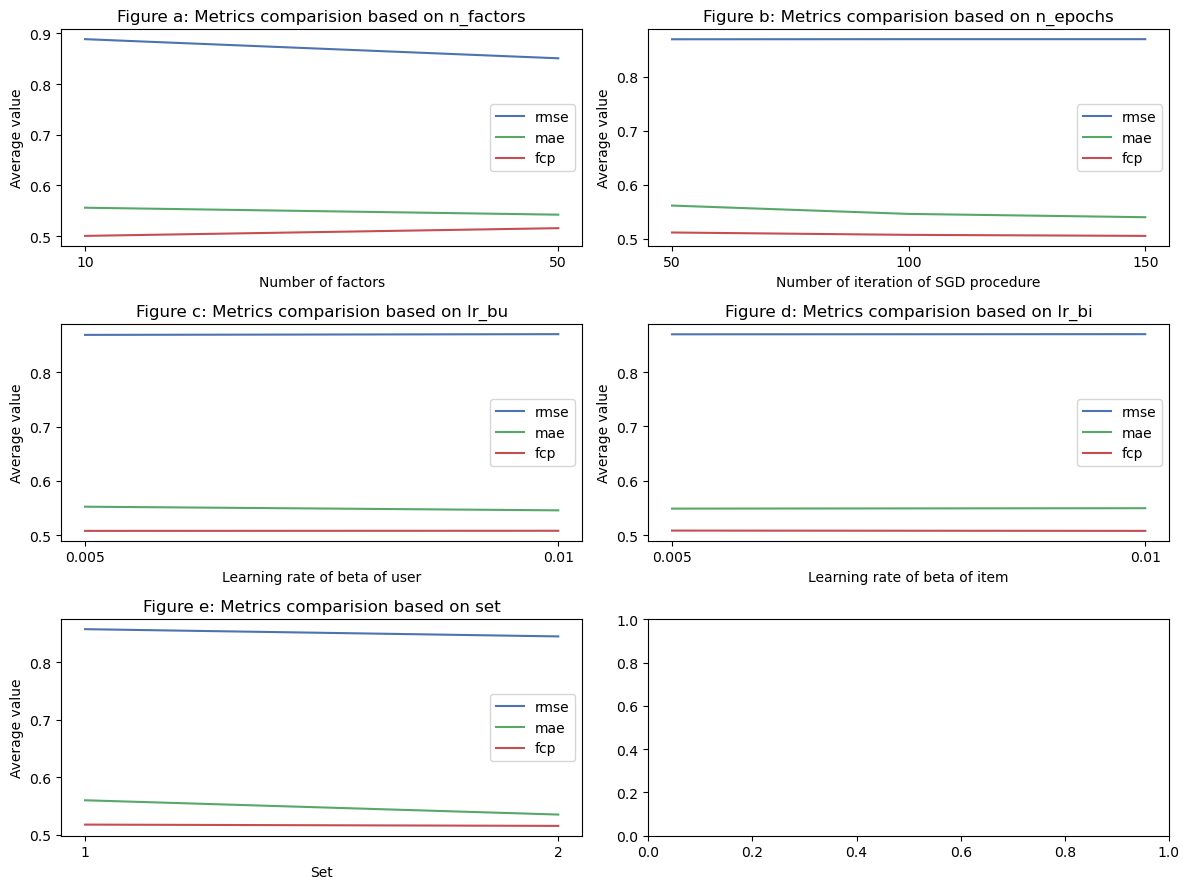

In [33]:
plt.style.use("seaborn-v0_8-deep")
# Create structure for the big plot
fig, ax = plt.subplots(3,2, figsize=(12, 9))

## Subplot 1
subplot_func(grouped_results_df1, 'n_factors', 0, 0, 
             'a', 'Number of factors', 'Average value')
## Subplot 2
subplot_func(grouped_results_df2, 'n_epochs', 0, 1, 
             'b', 'Number of iteration of SGD procedure', 'Average value')

## Subplot 3
subplot_func(grouped_results_df3, 'lr_bu', 1, 0, 
             'c', 'Learning rate of beta of user', 'Average value')

## Subplot 4
subplot_func(grouped_results_df4, 'lr_bi', 1, 1, 
             'd', 'Learning rate of beta of item', 'Average value')

## Subplot 5
subplot_func(best_params_df_long, 'set', 2, 0, 
             'e', 'Set', 'Average value')

plt.tight_layout()  # Adjust the layout to prevent overlaps
plt.savefig('../picture/CF_model_SVDpp.png', dpi=900)
plt.show()